# ToxicTrek

This is the notebook for the project - **ToxiTrek**.

## Sections


*   _Data Reading and Preprocessing_: We will read the data and do some preprocessing so that we have data in correct structure for model training.
*   _WordCloud_: Since we are dealing with text data hence we will use word cloud to understand the raw data better.
*   _Training Word2Vec Model_: Using the data we will train our own Language Model - **Word2Vec** so that output from this can serve as an input features to our classification models.
*   _PCA_ - We will just apply PCA on our data so that we can visualize it and understand the data better.
*   _Models_ - Lastly we will run our classifications models using embeddings from Word2Vec to classify whether a certain comment is toxic or not. Moreover, as we have class imbalance we will utilize SMOTE to cater for that and then run our models on balanced dataset.



## Setup

In [1]:
import numpy as np
import gensim
import pandas as pd
from nltk.corpus import stopwords
from gensim.models import Word2Vec,KeyedVectors
from collections import Counter
import re, nltk
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from wordcloud import WordCloud, STOPWORDS
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import copy
from sklearn.ensemble import AdaBoostClassifier

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Data Reading and Preprocessing









In [3]:
"""
We read in the data and each comment was labelled by multiple annotators and had value in toxicity column that had 1 if the comment was toxic and 0 if it was not.
Hence we took the mean of this column for every comment and if this mean was greater than or equal to 0.5 then we consider it as toxic else it was not toxic.
"""

# Here change the path to your data folder. Make sure the data path is correct

mydata1 = pd.read_table('/content/drive/MyDrive/Colab Notebooks/Project/toxicity_annotated_comments.tsv')
mydata2 = pd.read_table('/content/drive/MyDrive/Colab Notebooks/Project/toxicity_annotations.tsv')
labels = mydata2.groupby('rev_id')['toxicity'].mean().reset_index()
data = mydata1.merge(labels, how = 'left', on = 'rev_id')
data['toxicity'] = np.where(data['toxicity'] >= 0.5 , 1, 0)
data

,rev_id,comment,year,logged_in,ns,sample,split,toxicity
0,2232.0,This:NEWLINE_TOKEN:One can make an analogy in ...,2002,True,article,random,train,0
1,4216.0,`NEWLINE_TOKENNEWLINE_TOKEN:Clarification for ...,2002,True,user,random,train,0
2,8953.0,Elected or Electoral? JHK,2002,False,article,random,test,0
3,26547.0,`This is such a fun entry. DevotchkaNEWLINE_...,2002,True,article,random,train,0
4,28959.0,Please relate the ozone hole to increases in c...,2002,True,article,random,test,0
...,...,...,...,...,...,...,...,...
159681,699848324.0,`NEWLINE_TOKENNEWLINE_TOKENNEWLINE_TOKENThese ...,2016,True,article,blocked,train,0
159682,699851288.0,NEWLINE_TOKENNEWLINE_TOKENThe Institute for Hi...,2016,True,article,blocked,test,0
159683,699857133.0,NEWLINE_TOKEN:The way you're trying to describ...,2016,True,article,blocked,dev,0
159684,699891012.0,NEWLINE_TOKENNEWLINE_TOKEN== Warning ==NEWLINE...,2016,True,user,blocked,train,0


In [4]:
"""
Here we do some data preprocessing and data cleaning and removed all non alphabetic
characters and stop words.
"""
stop = stopwords.words('english')
data['comment'] = data['comment'].str.replace("NEWLINE_TOKEN", "",regex = True)
data['comment'] = data['comment'].str.replace("TAB_TOKEN", "",regex = True)
data['comment'] = data['comment'].str.replace("[^a-zA-Z ]", '', regex = True)
data['comment'] = data['comment'].str.replace("[:'=`]", '', regex=True)
data['comments'] = data['comment'].str.lower().str.strip().str.split(" ")
data['without_stop_words'] = data['comments'].apply(lambda x: [item for item in x if (item not in stop) and (item != "")])
data

,rev_id,comment,year,logged_in,ns,sample,split,toxicity,comments,without_stop_words
0,2232.0,ThisOne can make an analogy in mathematical te...,2002,True,article,random,train,0,"[thisone, can, make, an, analogy, in, mathemat...","[thisone, make, analogy, mathematical, terms, ..."
1,4216.0,Clarification for you and Zundarks right i sh...,2002,True,user,random,train,0,"[clarification, for, you, , and, zundarks, rig...","[clarification, zundarks, right, checked, wiki..."
2,8953.0,Elected or Electoral JHK,2002,False,article,random,test,0,"[elected, or, electoral, jhk]","[elected, electoral, jhk]"
3,26547.0,This is such a fun entry DevotchkaI once had...,2002,True,article,random,train,0,"[this, is, such, a, fun, entry, , , devotchkai...","[fun, entry, devotchkai, coworker, korea, coul..."
4,28959.0,Please relate the ozone hole to increases in c...,2002,True,article,random,test,0,"[please, relate, the, ozone, hole, to, increas...","[please, relate, ozone, hole, increases, cance..."
...,...,...,...,...,...,...,...,...,...,...
159681,699848324.0,These sources dont exactly exude a sense of im...,2016,True,article,blocked,train,0,"[these, sources, dont, exactly, exude, a, sens...","[sources, dont, exactly, exude, sense, imparti..."
159682,699851288.0,The Institute for Historical Review is a peerr...,2016,True,article,blocked,test,0,"[the, institute, for, historical, review, is, ...","[institute, historical, review, peerreviewed, ..."
159683,699857133.0,The way youre trying to describe it in this ar...,2016,True,article,blocked,dev,0,"[the, way, youre, trying, to, describe, it, in...","[way, youre, trying, describe, article, seriou..."
159684,699891012.0,Warning There is clearly a protectionist regi...,2016,True,user,blocked,train,0,"[warning, there, is, clearly, a, protectionist...","[warning, clearly, protectionist, regime, goin..."


In [5]:
""" Dropping rows where we had no feature i.e. without_stop_words list was empty """
index_names = data[data['without_stop_words'].apply(lambda x: len(x)) == 0 ].index
data.drop(index_names, inplace = True)
data.reset_index(inplace = True)

In [6]:
vocab_sentences = list(data['without_stop_words'])

## Word Cloud

We will generate the word cloud to understand the data a bit. This will tell us what words are most commonly used in the comments. We will generate word cloud separately for toxic and non toxic comments.

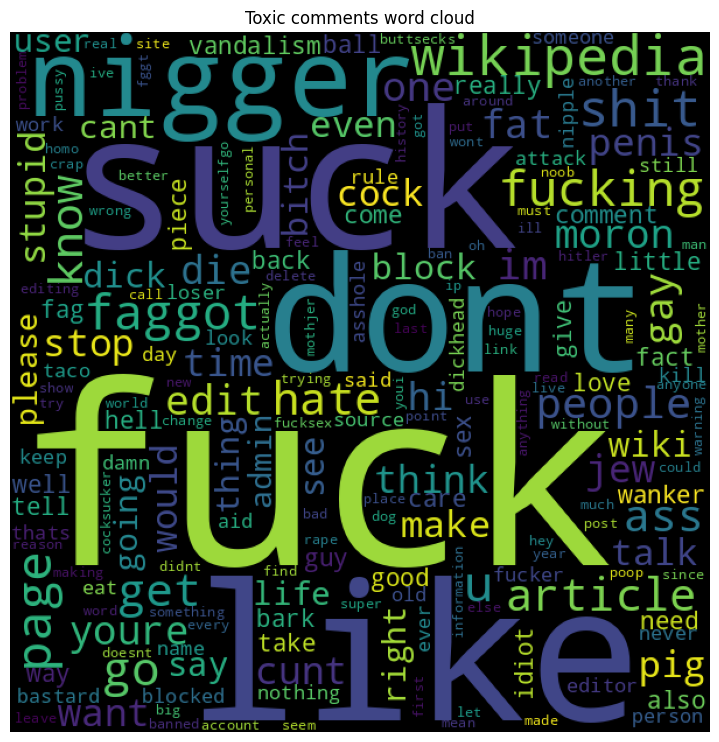

In [7]:
vocab_sentences_neg = list(data[data.toxicity==1]['without_stop_words'])
word_cloud = ""
for i in vocab_sentences_neg:
  word_cloud += " ".join(i)+" "

wordcloud = WordCloud(width = 600, height = 600,
                background_color ='black',
                stopwords = stop,
                min_font_size = 10,
                collocations = False).generate(word_cloud)

# plot the WordCloud image
plt.figure(figsize = (7, 7), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Toxic comments word cloud')

plt.show()

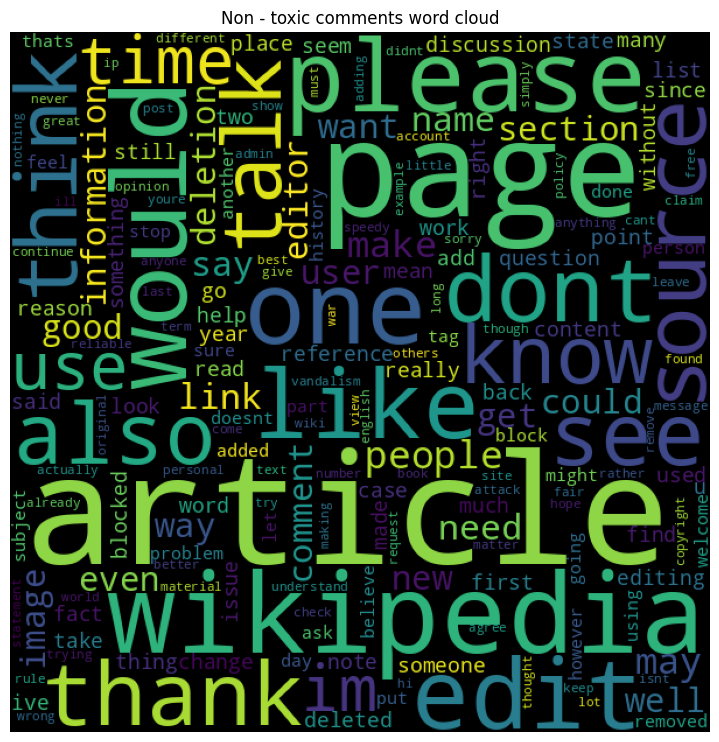

In [8]:
vocab_sentences_pos = list(data[data.toxicity==0]['without_stop_words'])
word_cloud = ""
for i in vocab_sentences_pos:
  word_cloud += " ".join(i)+" "

wordcloud = WordCloud(width = 600, height = 600,
                background_color ='black',
                stopwords = stop,
                min_font_size = 10,
                collocations = False).generate(word_cloud)

# plot the WordCloud image
plt.figure(figsize = (7, 7), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Non - toxic comments word cloud')

plt.show()

## Training Word2Vec model

In [9]:
model = Word2Vec(vocab_sentences,
                 min_count=1,
                 workers = 4,
                 vector_size=300,
                 window = 3)
model.save('/content/drive/MyDrive/Colab Notebooks/Project/mymodel')

In [10]:
""" Changing words to vector space, taking average to get embedding for the sentence """
data['vectors'] = data['without_stop_words'].apply(lambda x: [model.wv[item] for item in x])
data['final_vector'] = data['vectors'].apply(lambda x: [sum(x)/len(x)])
data

,index,rev_id,comment,year,logged_in,ns,sample,split,toxicity,comments,without_stop_words,vectors,final_vector
0,0,2232.0,ThisOne can make an analogy in mathematical te...,2002,True,article,random,train,0,"[thisone, can, make, an, analogy, in, mathemat...","[thisone, make, analogy, mathematical, terms, ...","[[0.008357359, -0.0063906726, -0.0018952868, 0...","[[-0.14966944, -0.2385448, 0.17084067, 0.27231..."
1,1,4216.0,Clarification for you and Zundarks right i sh...,2002,True,user,random,train,0,"[clarification, for, you, , and, zundarks, rig...","[clarification, zundarks, right, checked, wiki...","[[0.038359925, 0.739725, 0.049654424, 0.608476...","[[0.11406362, 0.23146103, -0.01147557, 0.18785..."
2,2,8953.0,Elected or Electoral JHK,2002,False,article,random,test,0,"[elected, or, electoral, jhk]","[elected, electoral, jhk]","[[-0.27934194, -0.21839797, -0.24935031, 0.274...","[[-0.16430344, -0.104841314, -0.17214023, 0.08..."
3,3,26547.0,This is such a fun entry DevotchkaI once had...,2002,True,article,random,train,0,"[this, is, such, a, fun, entry, , , devotchkai...","[fun, entry, devotchkai, coworker, korea, coul...","[[-0.111348994, 0.937261, -0.41604212, 0.46858...","[[-0.15467507, -0.011893084, 0.13467494, 0.276..."
4,4,28959.0,Please relate the ozone hole to increases in c...,2002,True,article,random,test,0,"[please, relate, the, ozone, hole, to, increas...","[please, relate, ozone, hole, increases, cance...","[[-0.43528765, 0.057230573, 1.5555091, -0.3358...","[[0.04443102, -0.08859485, 0.26588103, 0.31346..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
159598,159681,699848324.0,These sources dont exactly exude a sense of im...,2016,True,article,blocked,train,0,"[these, sources, dont, exactly, exude, a, sens...","[sources, dont, exactly, exude, sense, imparti...","[[1.4726598, -0.866713, 1.1081947, 0.006656830...","[[0.04170995, -0.1684381, 0.17191757, 0.295503..."
159599,159682,699851288.0,The Institute for Historical Review is a peerr...,2016,True,article,blocked,test,0,"[the, institute, for, historical, review, is, ...","[institute, historical, review, peerreviewed, ...","[[-0.45392886, 0.14905494, -0.42185825, 0.2573...","[[0.012952558, -0.061560053, 0.049671628, 0.30..."
159600,159683,699857133.0,The way youre trying to describe it in this ar...,2016,True,article,blocked,dev,0,"[the, way, youre, trying, to, describe, it, in...","[way, youre, trying, describe, article, seriou...","[[-0.48405477, 0.3271042, 0.76203924, -0.92980...","[[0.041937545, -0.07159168, 0.24772628, 0.1793..."
159601,159684,699891012.0,Warning There is clearly a protectionist regi...,2016,True,user,blocked,train,0,"[warning, there, is, clearly, a, protectionist...","[warning, clearly, protectionist, regime, goin...","[[0.23626664, 1.3427311, -0.32373202, 0.626867...","[[0.013260856, -0.015007391, 0.014702954, 0.28..."


In [11]:
X = np.concatenate( data['final_vector'], axis=0 )
X.shape

(159603, 300)

In [12]:
data['toxicity'].value_counts()


toxicity
0    141206
1     18397
Name: count, dtype: int64

## PCA

In [13]:
X_bkp = X.copy()
pca = PCA(n_components=3)
XX = pca.fit_transform(X)
print(XX.shape)

pca_2 = PCA(n_components=20)
X = pca_2.fit_transform(X)
print(X.shape)

(159603, 3)
(159603, 20)


In [14]:
y = np.array((data['toxicity']))
colormap = np.array(['r', 'g'])

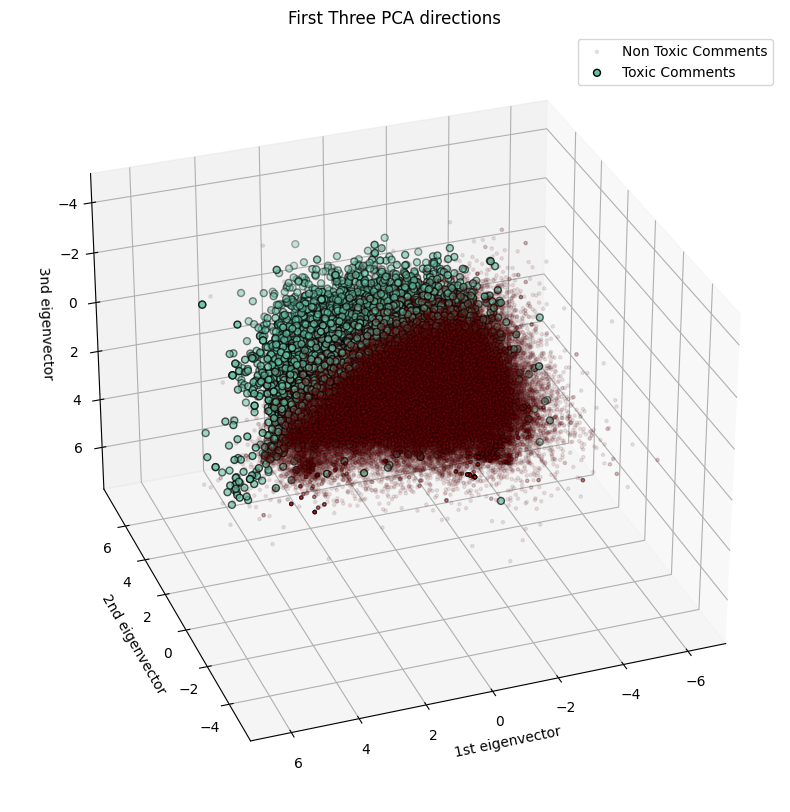

In [15]:
fig = plt.figure(1, figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)
ax.scatter(
    XX[np.where(y == 0), 0],
    XX[np.where(y == 0), 1],
    XX[np.where(y == 0), 2],
    c = y[np.where(y == 0)],
    cmap=plt.cm.Set1,
    edgecolor="k",
    s=5,
    alpha = 0.1,
    label = 'Non Toxic Comments' #set(y[np.where(y == 0)])
)

ax.scatter(
    XX[np.where(y == 1), 0],
    XX[np.where(y == 1), 1],
    XX[np.where(y == 1), 2],
    c = y[np.where(y == 1)],
    cmap=plt.cm.Set2,
    edgecolor="k",
    s=25,
    label = 'Toxic Comments' #set(y[np.where(y == 1)])
)


ax.set_title("First Three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.set_ylabel("2nd eigenvector")
ax.set_zlabel("3nd eigenvector")
ax.legend()
plt.show()

## Models


### Logistic Regression

accuracy:  0.9212502839062365
f1:  0.5744275616878995
recall:  0.4617583015786609
precision:  0.759825327510917
auc 0.92082287659331


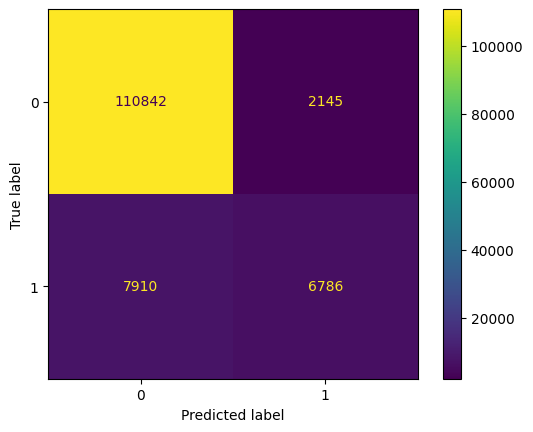

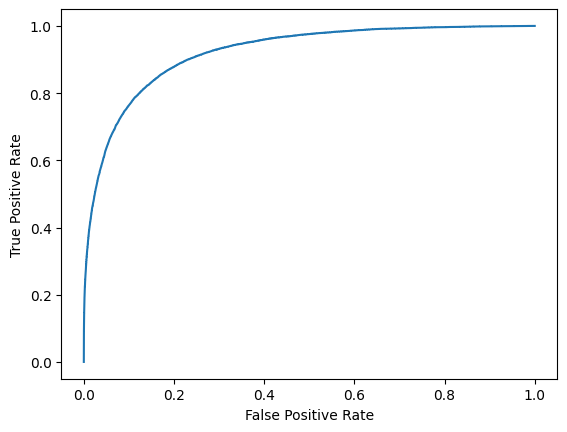

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, np.array(y), random_state=0, test_size = 0.8)
log_reg = LogisticRegression(penalty='l2',
                             solver='saga',
                             random_state=14,
                             max_iter= 100).fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

print('accuracy: ',accuracy_score(y_test, y_pred))
print('f1: ' ,f1_score(y_test, y_pred))
print('recall: ', recall_score(y_test, y_pred))
print('precision: ', precision_score(y_test, y_pred))
auc = roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1])
print('auc', auc)
fpr, tpr, _ = metrics.roc_curve(y_test, log_reg.predict_proba(X_test)[:, 1])
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()


accuracy:  0.9212267882176954
f1:  0.5742465289536065
recall:  0.4615541643984758
precision:  0.759744623655914
auc 0.9208322086630043


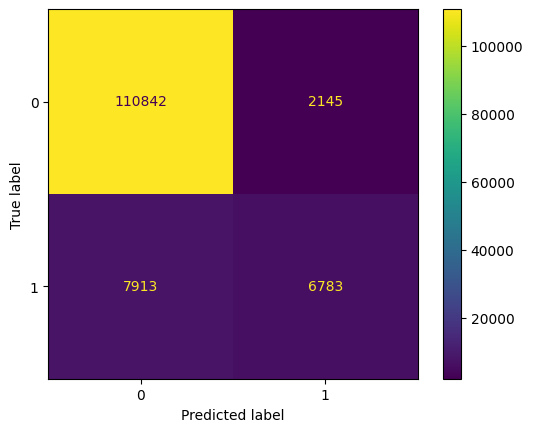

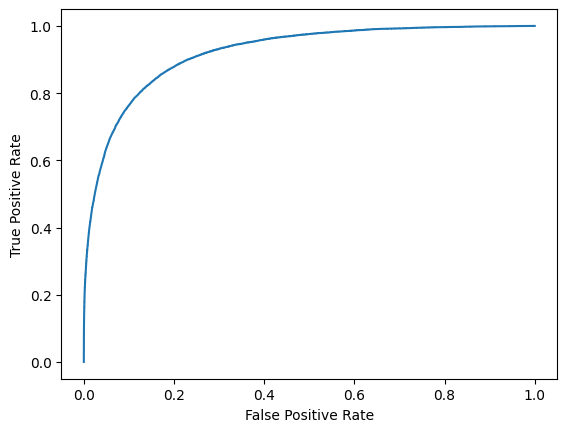

In [17]:
log_reg = LogisticRegression(penalty='l1',
                             solver='saga',
                             random_state=14,
                             max_iter= 100).fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

print('accuracy: ',accuracy_score(y_test, y_pred))
print('f1: ' ,f1_score(y_test, y_pred))
print('recall: ', recall_score(y_test, y_pred))
print('precision: ', precision_score(y_test, y_pred))
auc = roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1])
print('auc', auc)
fpr, tpr, _ = metrics.roc_curve(y_test, log_reg.predict_proba(X_test)[:, 1])
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


accuracy:  0.9211954606329739
f1:  0.5744014888757296
recall:  0.4620304844855743
precision:  0.758998435054773
auc 0.9208186199337252


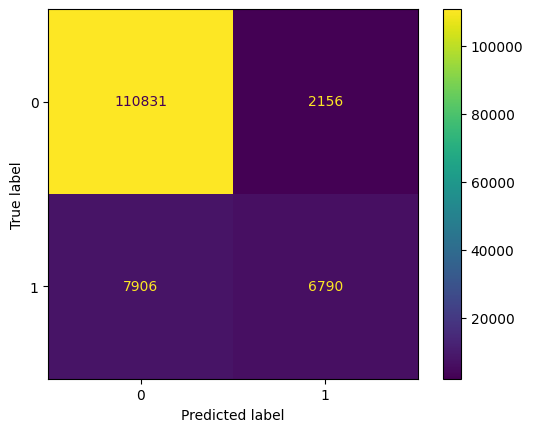

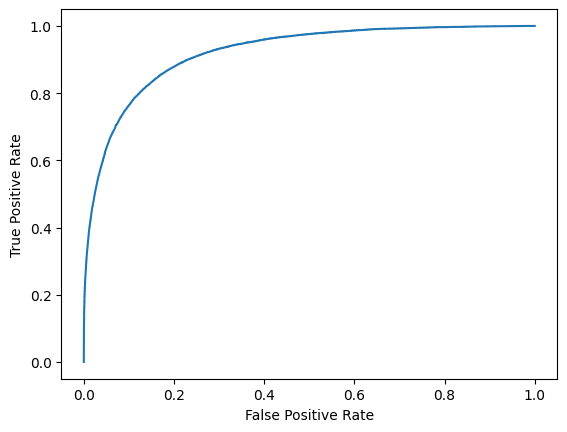

In [18]:
log_reg = LogisticRegression(penalty='none',
                             solver='saga',
                             random_state=14, max_iter= 100).fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

print('accuracy: ',accuracy_score(y_test, y_pred))
print('f1: ' ,f1_score(y_test, y_pred))
print('recall: ', recall_score(y_test, y_pred))
print('precision: ', precision_score(y_test, y_pred))
auc = roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1])
print('auc', auc)
fpr, tpr, _ = metrics.roc_curve(y_test, log_reg.predict_proba(X_test)[:, 1])
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

### KNN

accuracy:  0.9145148531911061
f1:  0.5935882637673604
recall:  0.5423924877517692
precision:  0.6554559657922868
auc 0.8338194936835676


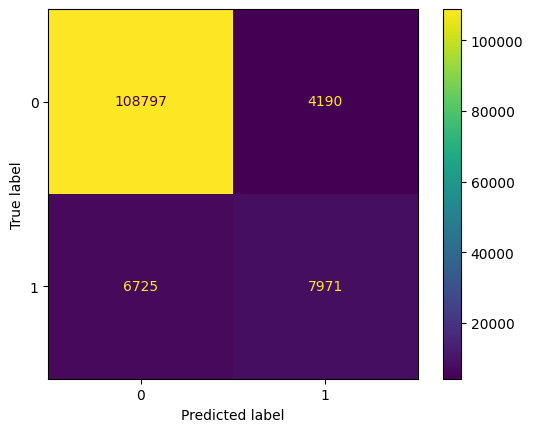

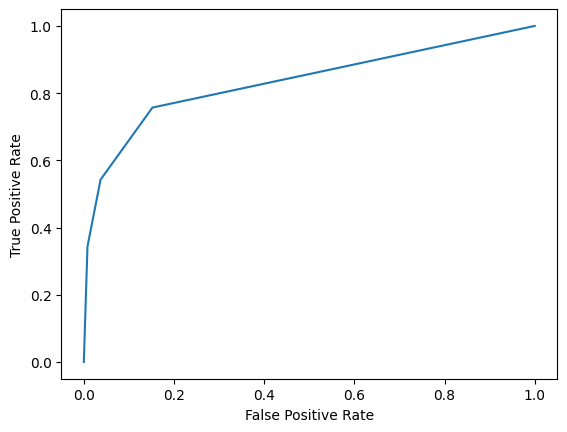

In [19]:
neigh = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
y_pred = neigh.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
print('accuracy: ',accuracy_score(y_test, y_pred))
print('f1: ' ,f1_score(y_test, y_pred))
print('recall: ', recall_score(y_test, y_pred))
print('precision: ', precision_score(y_test, y_pred))
auc = roc_auc_score(y_test, neigh.predict_proba(X_test)[:, 1])
print('auc', auc)
fpr, tpr, _ = metrics.roc_curve(y_test, neigh.predict_proba(X_test)[:, 1])
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

accuracy:  0.92111714167117
f1:  0.6085503303536728
recall:  0.5327299945563418
precision:  0.7095341671198115
auc 0.8624403443733482


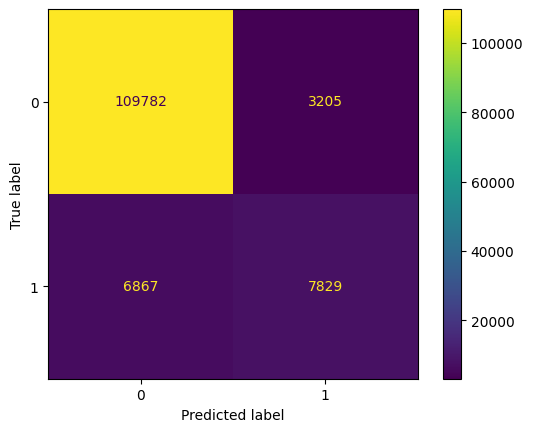

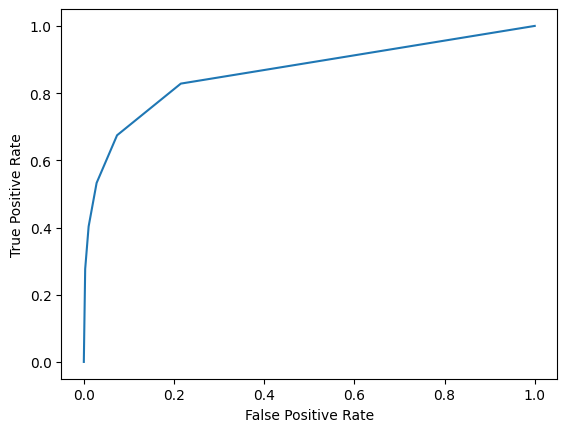

In [20]:
neigh = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)
y_pred = neigh.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
print('accuracy: ',accuracy_score(y_test, y_pred))
print('f1: ' ,f1_score(y_test, y_pred))
print('recall: ', recall_score(y_test, y_pred))
print('precision: ', precision_score(y_test, y_pred))
auc = roc_auc_score(y_test, neigh.predict_proba(X_test)[:, 1])
print('auc', auc)
fpr, tpr, _ = metrics.roc_curve(y_test, neigh.predict_proba(X_test)[:, 1])
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

accuracy:  0.9240149432579122
f1:  0.615030553130704
recall:  0.5273543821448013
precision:  0.7376737102608033
auc 0.8785573117345111


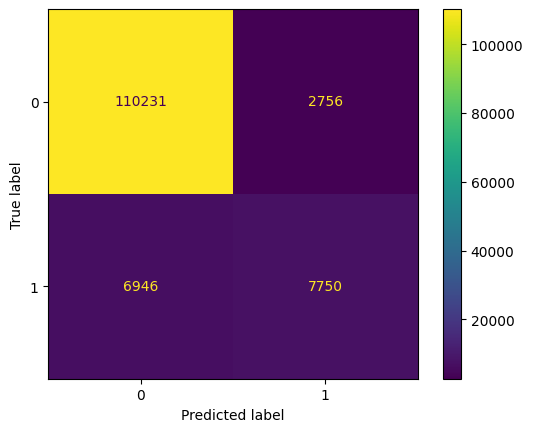

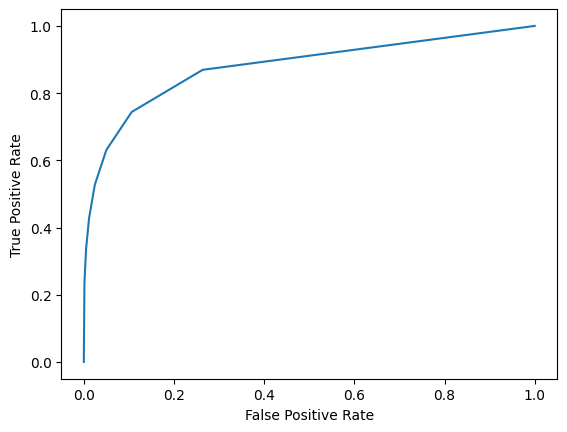

In [21]:
neigh = KNeighborsClassifier(n_neighbors=7).fit(X_train, y_train)
y_pred = neigh.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
print('accuracy: ',accuracy_score(y_test, y_pred))
print('f1: ' ,f1_score(y_test, y_pred))
print('recall: ', recall_score(y_test, y_pred))
print('precision: ', precision_score(y_test, y_pred))
auc = roc_auc_score(y_test, neigh.predict_proba(X_test)[:, 1])
print('auc', auc)
fpr, tpr, _ = metrics.roc_curve(y_test, neigh.predict_proba(X_test)[:, 1])
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

### Naive Bayes

accuracy:  0.9220648011089965
f1:  0.542251253507521
recall:  0.40106151333696244
precision:  0.836859292914951
auc 0.8992796517256534


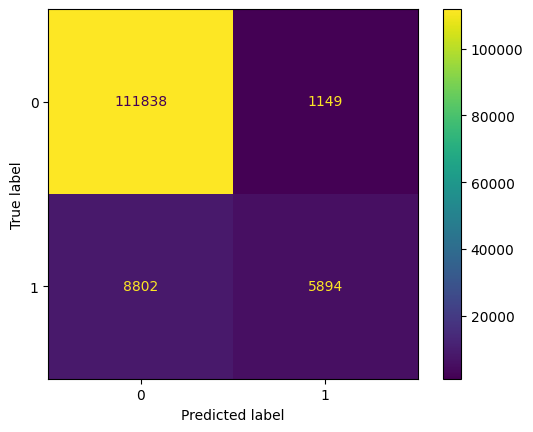

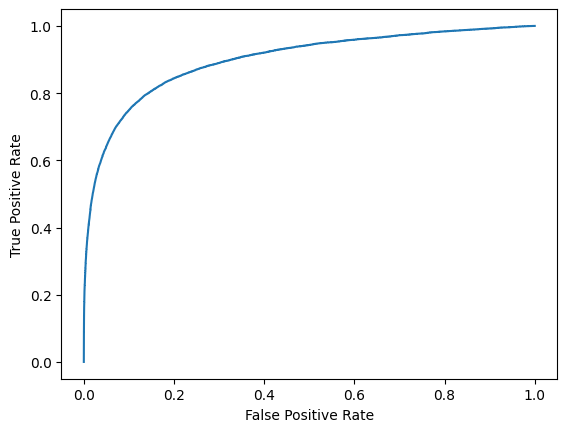

In [22]:
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
print('accuracy: ',accuracy_score(y_test, y_pred))
print('f1: ' ,f1_score(y_test, y_pred))
print('recall: ', recall_score(y_test, y_pred))
print('precision: ', precision_score(y_test, y_pred))
auc = roc_auc_score(y_test, gnb.predict_proba(X_test)[:, 1])
print('auc', auc)
fpr, tpr, _ = metrics.roc_curve(y_test, gnb.predict_proba(X_test)[:, 1])
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

### RandomForest

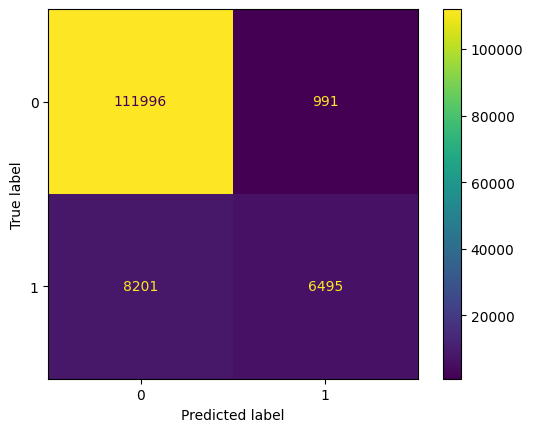

In [23]:
rf = RandomForestClassifier(max_depth=12,n_estimators = 500, random_state=0)
y_pred = rf.fit(X_train, y_train).predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

accuracy:  0.9280092103099081
f1:  0.5856099540167704
recall:  0.4419569951007077
precision:  0.8676195565054768
auc 0.9233423854519778


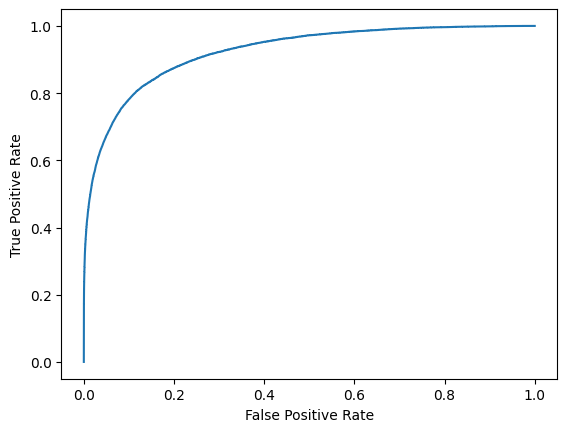

In [24]:
print('accuracy: ',accuracy_score(y_test, y_pred))
print('f1: ' ,f1_score(y_test, y_pred))
print('recall: ', recall_score(y_test, y_pred))
print('precision: ', precision_score(y_test, y_pred))
auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
print('auc', auc)
fpr, tpr, _ = metrics.roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

### AdaBoost

accruracy:  0.9280796973755316
f1:  0.6426709210475116
recall:  0.5619216113228089
precision:  0.7505225847496138
auc 0.9222011083488781


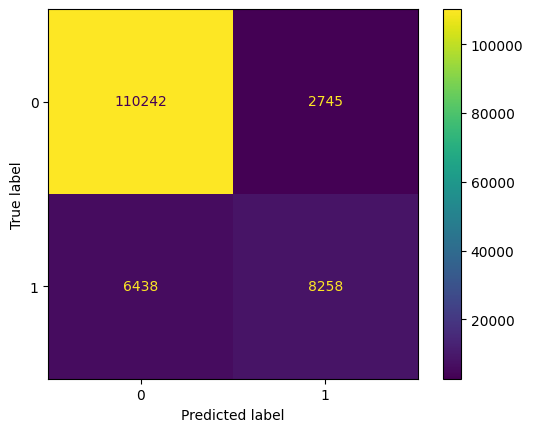

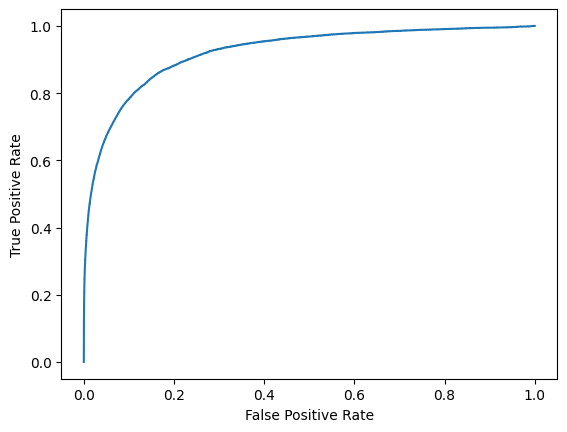

In [25]:
ada = AdaBoostClassifier(n_estimators=545, random_state=5)
y_pred = ada.fit(X_train, y_train).predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

print('accruracy: ',accuracy_score(y_test, y_pred))
print('f1: ' ,f1_score(y_test, y_pred))
print('recall: ', recall_score(y_test, y_pred))
print('precision: ', precision_score(y_test, y_pred))
auc = roc_auc_score(y_test, ada.predict_proba(X_test)[:, 1])
print('auc', auc)
fpr, tpr, _ = metrics.roc_curve(y_test, ada.predict_proba(X_test)[:, 1])
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()


### SMOTE Models


#### Logistic regression

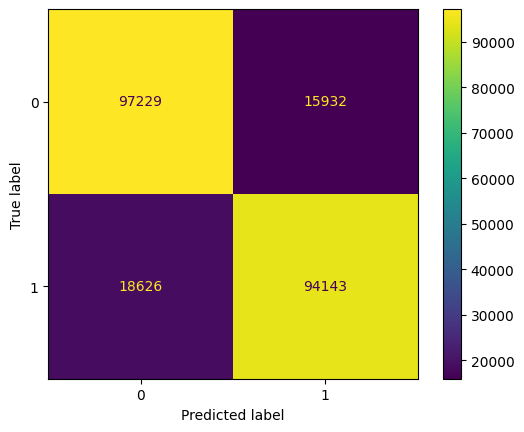

In [26]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y_res, random_state=0, test_size = 0.8)
log_reg = LogisticRegression(random_state=0).fit(X_train_res, y_train_res)
y_pred_res = log_reg.predict(X_test_res)
cm = confusion_matrix(y_test_res, y_pred_res)
cm_display = ConfusionMatrixDisplay(cm).plot()

accruracy:  0.8470411189306423
f1:  0.844922905709824
recall:  0.8348304941961
precision:  0.855262321144674
auc 0.927130029205414


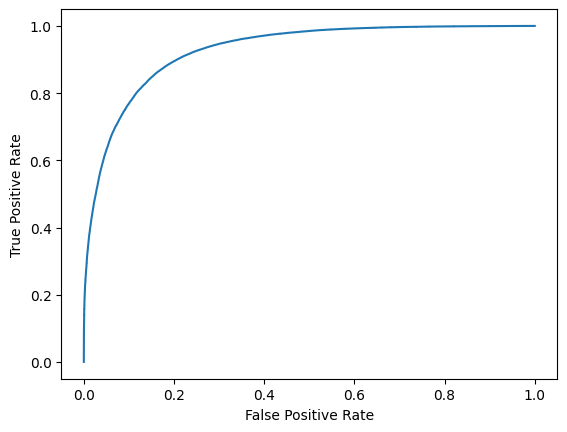

In [27]:
print('accruracy: ',accuracy_score(y_test_res, y_pred_res))
print('f1: ' ,f1_score(y_test_res, y_pred_res))
print('recall: ', recall_score(y_test_res, y_pred_res))
print('precision: ', precision_score(y_test_res, y_pred_res))
auc = roc_auc_score(y_test_res, log_reg.predict_proba(X_test_res)[:, 1])
print('auc', auc)
fpr, tpr, _ = metrics.roc_curve(y_test_res, log_reg.predict_proba(X_test_res)[:, 1])
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

#### KNN

accruracy:  0.8785243216925597
f1:  0.8886472538128527
recall:  0.9711179490817512
precision:  0.8190875093492894
auc 0.9347165818158476


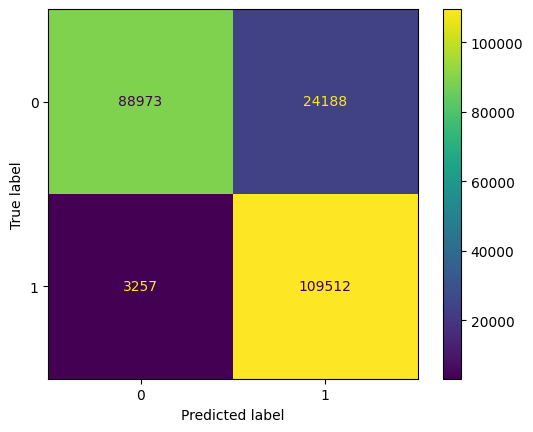

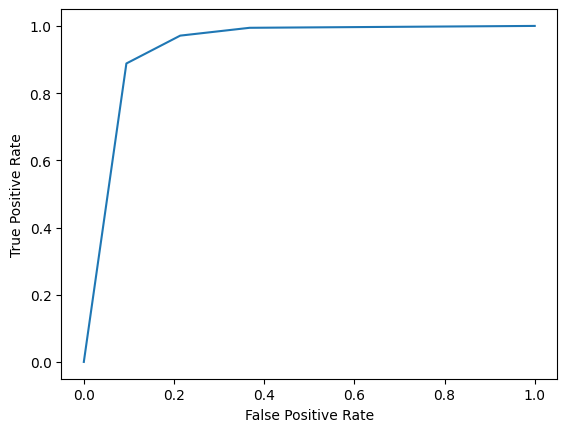

In [28]:
neigh = KNeighborsClassifier(n_neighbors=3).fit(X_train_res, y_train_res)
y_pred_res = neigh.predict(X_test_res)
cm = confusion_matrix(y_test_res, y_pred_res)
cm_display = ConfusionMatrixDisplay(cm).plot()
print('accruracy: ',accuracy_score(y_test_res, y_pred_res))
print('f1: ' ,f1_score(y_test_res, y_pred_res))
print('recall: ', recall_score(y_test_res, y_pred_res))
print('precision: ', precision_score(y_test_res, y_pred_res))
auc = roc_auc_score(y_test_res, neigh.predict_proba(X_test_res)[:, 1])
print('auc', auc)
fpr, tpr, _ = metrics.roc_curve(y_test_res, neigh.predict_proba(X_test_res)[:, 1])
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

accruracy:  0.8724693489133802
f1:  0.8827219036067094
recall:  0.9615585843627238
precision:  0.8158330323823282
auc 0.9436738668620613


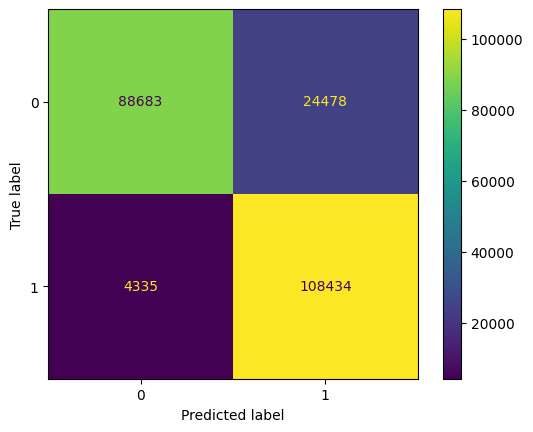

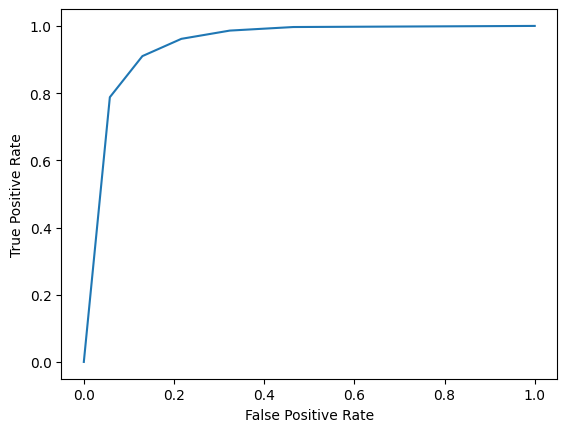

In [29]:
neigh = KNeighborsClassifier(n_neighbors=5).fit(X_train_res, y_train_res)
y_pred_res = neigh.predict(X_test_res)
cm = confusion_matrix(y_test_res, y_pred_res)
cm_display = ConfusionMatrixDisplay(cm).plot()
print('accruracy: ',accuracy_score(y_test_res, y_pred_res))
print('f1: ' ,f1_score(y_test_res, y_pred_res))
print('recall: ', recall_score(y_test_res, y_pred_res))
print('precision: ', precision_score(y_test_res, y_pred_res))
auc = roc_auc_score(y_test_res, neigh.predict_proba(X_test_res)[:, 1])
print('auc', auc)
fpr, tpr, _ = metrics.roc_curve(y_test_res, neigh.predict_proba(X_test_res)[:, 1])
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

accruracy:  0.8696764484574868
f1:  0.8798596376693324
recall:  0.9560960902375653
precision:  0.8148831162941856
auc 0.9459376079054043


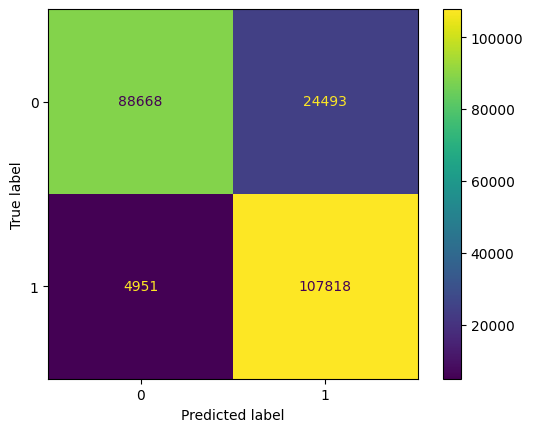

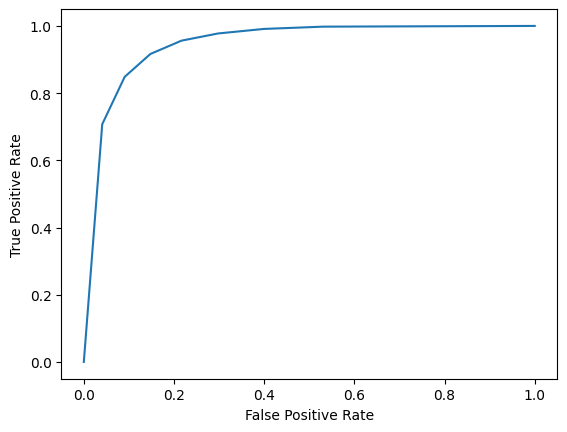

In [30]:
neigh = KNeighborsClassifier(n_neighbors=7).fit(X_train_res, y_train_res)
y_pred_res = neigh.predict(X_test_res)
cm = confusion_matrix(y_test_res, y_pred_res)
cm_display = ConfusionMatrixDisplay(cm).plot()
print('accruracy: ',accuracy_score(y_test_res, y_pred_res))
print('f1: ' ,f1_score(y_test_res, y_pred_res))
print('recall: ', recall_score(y_test_res, y_pred_res))
print('precision: ', precision_score(y_test_res, y_pred_res))
auc = roc_auc_score(y_test_res, neigh.predict_proba(X_test_res)[:, 1])
print('auc', auc)
fpr, tpr, _ = metrics.roc_curve(y_test_res, neigh.predict_proba(X_test_res)[:, 1])
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

#### Naive Bayes

accruracy:  0.7740007967069447
f1:  0.7928180158247109
recall:  0.8663285122684425
precision:  0.7308069209536134
auc 0.8847247330986263


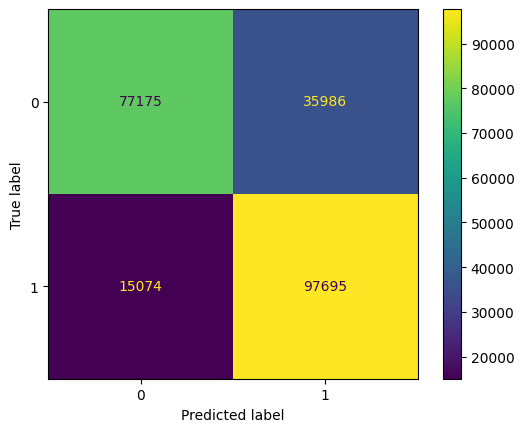

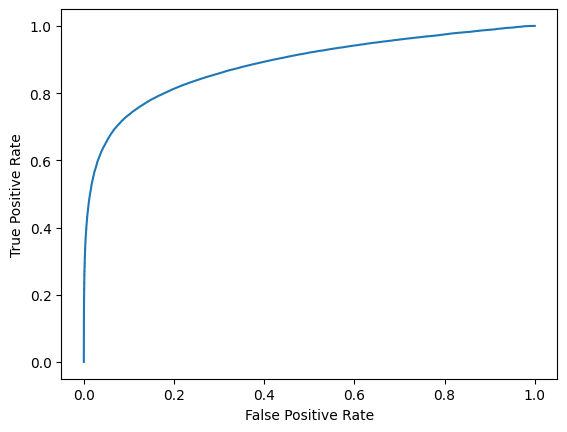

In [31]:
gnb = GaussianNB()
y_pred_res = gnb.fit(X_train_res, y_train_res).predict(X_test_res)
cm = confusion_matrix(y_test_res, y_pred_res)
cm_display = ConfusionMatrixDisplay(cm).plot()
print('accruracy: ',accuracy_score(y_test_res, y_pred_res))
print('f1: ' ,f1_score(y_test_res, y_pred_res))
print('recall: ', recall_score(y_test_res, y_pred_res))
print('precision: ', precision_score(y_test_res, y_pred_res))
auc = roc_auc_score(y_test_res, gnb.predict_proba(X_test_res)[:, 1])
print('auc', auc)
fpr, tpr, _ = metrics.roc_curve(y_test_res, gnb.predict_proba(X_test_res)[:, 1])
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

#### RandomForest

accruracy:  0.884880272650821
f1:  0.8854647860033555
recall:  0.8915304738004238
precision:  0.8794810784330878
auc 0.9558723754671048


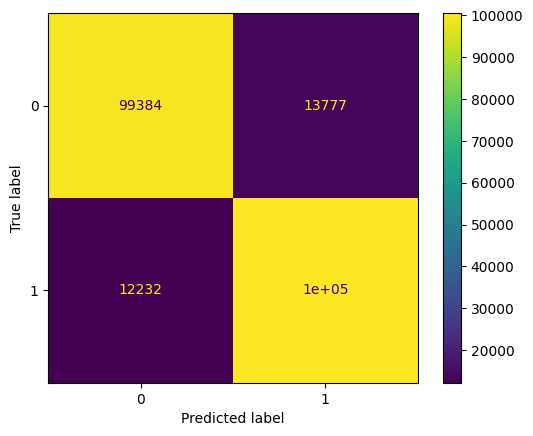

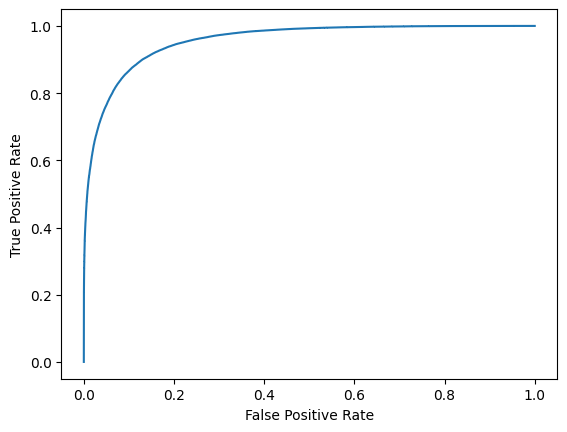

In [32]:
rf = RandomForestClassifier(max_depth=12, n_estimators = 300, random_state=14)
y_pred_res = rf.fit(X_train_res, y_train_res).predict(X_test_res)
cm = confusion_matrix(y_test_res, y_pred_res)
cm_display = ConfusionMatrixDisplay(cm).plot()
print('accruracy: ',accuracy_score(y_test_res, y_pred_res))
print('f1: ' ,f1_score(y_test_res, y_pred_res))
print('recall: ', recall_score(y_test_res, y_pred_res))
print('precision: ', precision_score(y_test_res, y_pred_res))
auc = roc_auc_score(y_test_res, rf.predict_proba(X_test_res)[:, 1])
print('auc', auc)
fpr, tpr, _ = metrics.roc_curve(y_test_res, rf.predict_proba(X_test_res)[:, 1])
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

#### AdaBoost

accruracy:  0.8688885938122427
f1:  0.8686094477711244
recall:  0.8682705353421596
precision:  0.8689486248790834
auc 0.9427153214988313


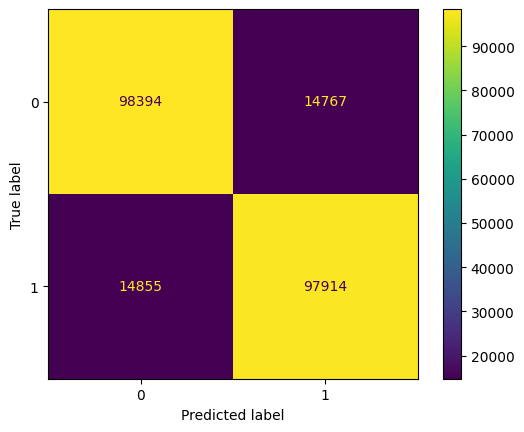

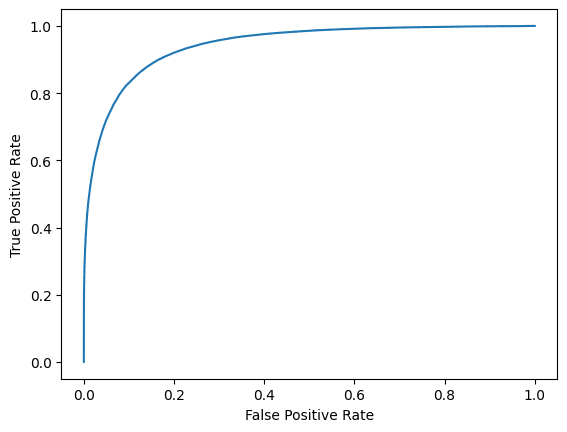

In [33]:
ada = AdaBoostClassifier(n_estimators = 545, random_state=14)
y_pred_res = ada.fit(X_train_res, y_train_res).predict(X_test_res)
cm = confusion_matrix(y_test_res, y_pred_res)
cm_display = ConfusionMatrixDisplay(cm).plot()
print('accruracy: ',accuracy_score(y_test_res, y_pred_res))
print('f1: ' ,f1_score(y_test_res, y_pred_res))
print('recall: ', recall_score(y_test_res, y_pred_res))
print('precision: ', precision_score(y_test_res, y_pred_res))
auc = roc_auc_score(y_test_res, ada.predict_proba(X_test_res)[:, 1])
print('auc', auc)
fpr, tpr, _ = metrics.roc_curve(y_test_res, ada.predict_proba(X_test_res)[:, 1])
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()